Notebook to analyze tropical cyclone (TC) list compiled from IBTrACS data by Frederick Tam.

TC list has already been subsetted for:
- TCs that reach at least category 3 on the SS scale
- mean shear ≤ 11 m/s

Details:  
- distance = distance at final time step when the storms were classified as TD
- "hurricane" period = time from first status as a hurricane up to first status as TS

Parent dataset: International Best Track Archive for Climate Stewardship [IBTrACS](https://www.ncei.noaa.gov/products/international-best-track-archive)


James Ruppert  
jruppert@ou.edu  
10/07/24

### Main settings

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tropycal import tracks, recon, utils

In [3]:
list_path = "../storm-lists/stormlist_withMPIdistance.csv"
df = pd.read_csv(list_path)#, sep=',', on_bad_lines='skip', skiprows=4)
df

,Unnamed: 0,index,name,id,mean_shear,time_before_tcg,mean_shear_hu,time_before_hu,lat,E_MPI,distance
0,0,13,2000_SHANSHAN,"['wp262000', 'WP_26']",6.241797,60,3.094575,36,15.1500,63.411490,2970.382269
1,1,19,2000_SAOMAI,"['wp222000', 'WP_22']",3.096483,24,4.882538,36,15.9900,70.234010,2224.307203
2,2,24,2000_BILIS,"['wp182000', 'WP_18']",2.984449,36,3.176979,24,12.5308,77.146203,1236.925745
3,3,2,2001_KROSA,"['wp242001', 'WP_24']",3.947990,24,5.985582,24,15.1077,NaN,1881.174024
4,4,3,2001_LINGLING,"['wp272001', 'WP_27']",6.502896,48,8.491656,48,10.7000,NaN,27.310874
...,...,...,...,...,...,...,...,...,...,...,...
258,258,9,2019_LORENZO,"['al132019', 'AL_13']",4.807510,12,5.775757,48,11.0000,81.592855,452.060978
259,259,16,2020_ETA,"['al292020', 'AL_29']",4.185665,12,4.129712,36,14.9000,98.657236,361.383512
260,260,17,2020_LAURA,"['al132020', 'AL_13']",7.504969,36,10.385125,108,17.0000,83.262945,826.302321
261,261,24,2020_TEDDY,"['al202020', 'AL_20']",9.231384,48,7.003615,48,12.9000,83.946964,1402.462279


### Plots

#### Plot functions

In [4]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})

In [5]:
def add_var(figdata, ax, toggle=0):
    ax.set_title(figdata['vartag'])
    ax.set_ylabel('Count')
    ax.set_xlabel('Units = '+figdata['units'])
    sns.histplot(figdata['pltvar'], ax=ax, kde=True, bins=figdata['bins'])#, label=figdata['count'])
    default_colors = sns.color_palette()
    median = np.nanmedian(figdata['pltvar'])
    if toggle == 0:
        linestyle='-.'
    else:
        linestyle='--'
    ax.axvline(median, color=default_colors[toggle], linestyle=linestyle, label='Median = '+str(round(median, 2)))
    ax.legend()

#### Using selection critera

In [6]:
# Selection based on distance from coast
min_dfc = 500 # [km] max distance from coast
subset = df[df['distance'] >= min_dfc]

# Selection based on E-MPI
min_mpi_percentile = 33
min_empi = np.nanpercentile(df['E_MPI'], min_mpi_percentile)
print('Minimum E-MPI:', np.round(min_empi, 1))
subset = subset[subset['E_MPI'] >= min_empi]

# Selection based on E-MPI
max_shear = 11
subset = subset[subset['mean_shear_hu'] <= max_shear]

# Number of cases in original dataset
n_original = "Count = "+str(len(df))
print('Number of cases in original dataset:', n_original)
# Number of cases in selected subset
n_subset = "Count = "+str(len(subset))
print('Number of cases in selected subset:', n_subset)

Minimum E-MPI: 73.3
Number of cases in original dataset: Count = 263
Number of cases in selected subset: Count = 105


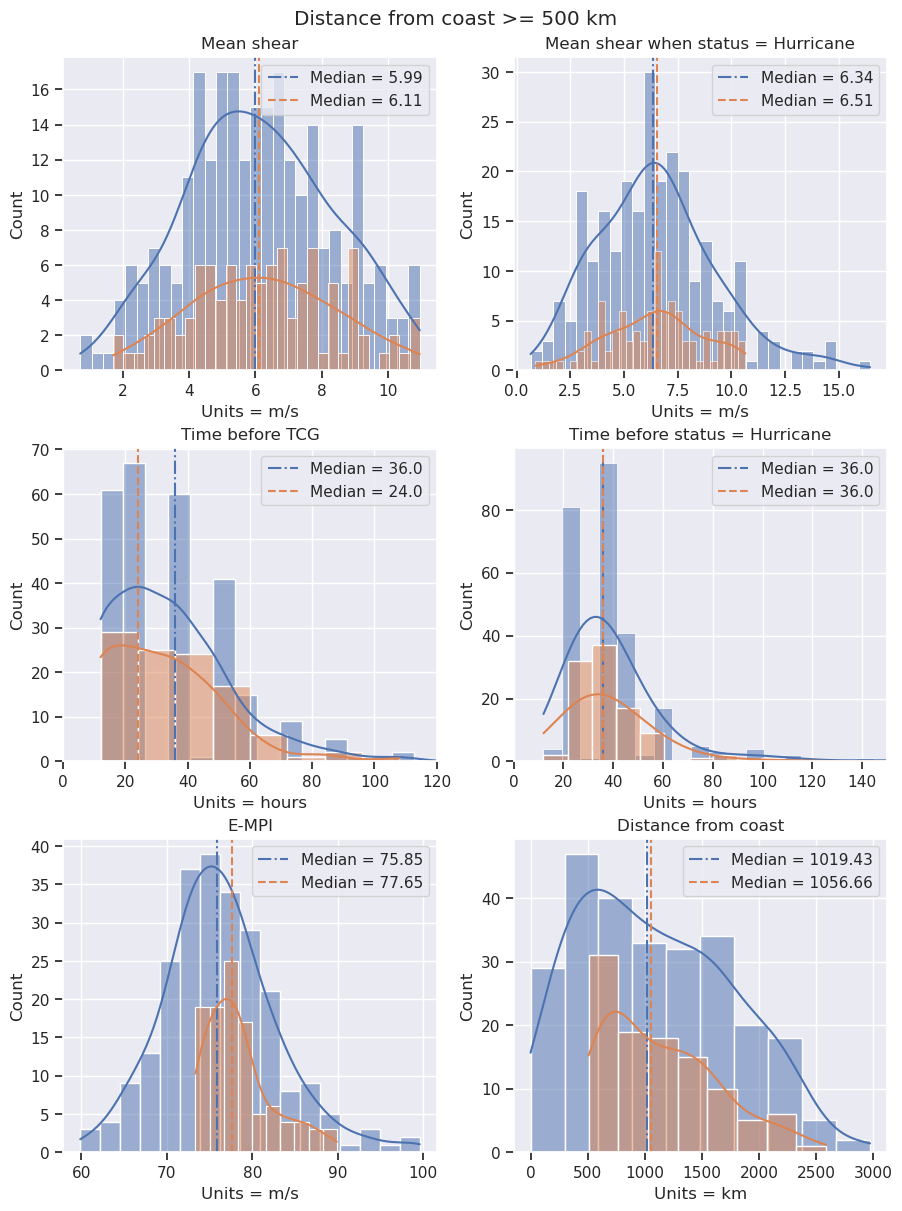

In [7]:
fig_x = 9
fig_y = 12
fig, axs = plt.subplots(3, 2, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)

plt.suptitle('Distance from coast >= '+str(min_dfc)+' km')

# for idataset in [df, subset]:
for itoggle in range(2):

    if itoggle == 0:
        idataset = df
    else:
        idataset = subset

    figdata = {
        'pltvar': idataset['mean_shear'],
        'vartag': 'Mean shear',
        'units': 'm/s',
        'bins': 30,
        'count': n_original if itoggle == 0 else n_subset,
            }

    add_var(figdata, axs[0,0], toggle=itoggle)

    ################################

    figdata = {
        'pltvar': idataset['mean_shear_hu'],
        'vartag': 'Mean shear when status = Hurricane',
        'units': 'm/s',
        'bins': 30,
        'count': n_original if itoggle == 0 else n_subset,
            }

    add_var(figdata, axs[0,1], toggle=itoggle)

    ################################

    figdata = {
        'pltvar': idataset['time_before_tcg'],
        'vartag': 'Time before TCG',
        'units': 'hours',
        'bins': 'auto',
        'count': n_original if itoggle == 0 else n_subset,
            }

    add_var(figdata, axs[1,0], toggle=itoggle)
    axs[1,0].set_xlim(0, 120)

    ################################

    figdata = {
        'pltvar': idataset['time_before_hu'],
        'vartag': 'Time before status = Hurricane',
        'units': 'hours',
        'bins': 'auto',
        'count': n_original if itoggle == 0 else n_subset,
            }

    add_var(figdata, axs[1,1], toggle=itoggle)
    axs[1,1].set_xlim(0, 150)

    ################################

    figdata = {
        'pltvar': idataset['E_MPI'],
        'vartag': 'E-MPI',
        'units': 'm/s',
        'bins': 'auto',
        'count': n_original if itoggle == 0 else n_subset,
            }

    add_var(figdata, axs[2,0], toggle=itoggle)

    ################################

    figdata = {
        'pltvar': idataset['distance'],
        'vartag': 'Distance from coast',
        'units': 'km',
        'bins': 'auto',
        'count': n_original if itoggle == 0 else n_subset,
            }

    add_var(figdata, axs[2,1], toggle=itoggle)

# axs[0,1].legend()#loc='upper right')
plt.show()
plt.close()

In [9]:
subset.sort_values(by='mean_shear', ascending=True)

,Unnamed: 0,index,name,id,mean_shear,time_before_tcg,mean_shear_hu,time_before_hu,lat,E_MPI,distance
216,216,18,2018_JOHN,"['ep122018', 'EP_12']",1.710493,12,1.306103,24,14.500,81.717907,532.678221
106,106,6,2015_NANGKA,"['wp112015', 'WP_11']",1.847070,12,5.056706,60,9.640,73.707341,2281.291173
113,113,0,2016_NEPARTAK,"['wp022016', 'WP_02']",2.227425,24,6.398365,36,10.025,77.448597,1362.745864
99,99,5,2014_VONGFONG,"['wp192014', 'WP_19']",2.444245,36,7.665899,48,8.060,78.922741,1467.928946
206,206,1,2017_EUGENE,"['ep052017', 'EP_05']",2.716890,12,3.332122,36,11.600,76.878972,1064.686982
...,...,...,...,...,...,...,...,...,...,...,...
63,63,21,2008_HAGUPIT,"['wp182008', 'WP_18']",10.324381,48,7.991204,60,14.120,73.938295,835.894747
45,45,12,2006_CHEBI,"['wp232006', 'WP_23']",10.410829,60,5.791017,12,15.850,78.644531,507.735370
43,43,4,2006_DURIAN,"['wp242006', 'WP_24']",10.701113,48,10.158887,60,9.975,76.606816,1375.033390
240,240,5,2009_FRED,"['al072009', 'AL_07']",10.731442,12,6.513578,24,11.700,76.042831,581.683099


In [14]:
# Print list of storms
for i, storm_subset in subset.iterrows():
    print(storm_subset['name'])
# subset['name']

2000_BILIS
2003_KUJIRA
2003_ETAU
2003_KETSANA
2004_DIANMU
2004_SUDAL
2004_SONGDA
2004_NOCK-TEN
2005_NESAT
2006_SAOMAI
2006_DURIAN
2006_EWINIAR
2006_CHEBI
2006_CIMARON
2006_UTOR
2007_MITAG
2007_KAJIKI
2008_JANGMI
2008_FENGSHEN
2008_HAGUPIT
2009_NIDA
2009_LUPIT
2010_CHABA
2010_MEGI
2011_SONGDA
2012_SANBA
2012_PRAPIROON
2012_JELAWAT
2013_FRANCISCO
2014_VONGFONG
2014_NURI
2014_PHANFONE
2015_IN-FA
2015_NANGKA
2016_NEPARTAK
2016_HAIMA
2017_LAN
2018_YUTU
2018_CIMARON
2018_MANGKHUT
2018_JEBI
2018_TRAMI
2018_MARIA
2019_NEOGURI
2019_FAXAI
2019_BUALOI
2019_HAGIBIS
2000_DANIEL
2002_FAUSTO
2002_ELIDA
2004_DARBY
2005_KENNETH
2006_DANIEL
2006_SERGIO
2006_HECTOR
2006_ILEANA
2011_KENNETH
2011_JOVA
2012_EMILIA
2012_DANIEL
2012_MIRIAM
2012_FABIO
2014_VANCE
2015_GUILLERMO
2015_JIMENA
2015_SANDRA
2015_LINDA
2016_DARBY
2016_LESTER
2016_ORLENE
2016_BLAS
2016_SEYMOUR
2017_EUGENE
2017_HILARY
2017_KENNETH
2017_FERNANDA
2018_ALETTA
2018_LANE
2018_OLIVIA
2018_NORMAN
2018_ROSA
2018_JOHN
2018_HECTOR
2019_KIKO
2019_

#### Map of TCs

In [31]:
# Get storm tracks

storm_names = df['name']
years = storm_names.apply(lambda x: x[0:4] if isinstance(x, str) else x)
storm_names = storm_names.apply(lambda x: x[5:] if isinstance(x, str) else x)
storm_ids = df['id'].apply(lambda x: x[2:10])

basin = tracks.TrackDataset(source='ibtracs', basin='all')

subset_lon = []
subset_lat = []
for istorm in storm_ids:#[0:3]:
    storm = basin.get_storm(istorm.upper())
    subset_lon.append(storm.vars['lon'])
    subset_lat.append(storm.vars['lat'])

array([134.7, 133.8, 132.8, 131.9, 130.8, 129.6, 128.3, 127.4, 126.8,
       126.1, 125.6, 124.8, 124.2, 123.7, 123.1, 122.8, 122.4, 122. ,
       121.3, 121. , 120.6, 120.2, 119.8, 119.5, 119.3, 119.8])

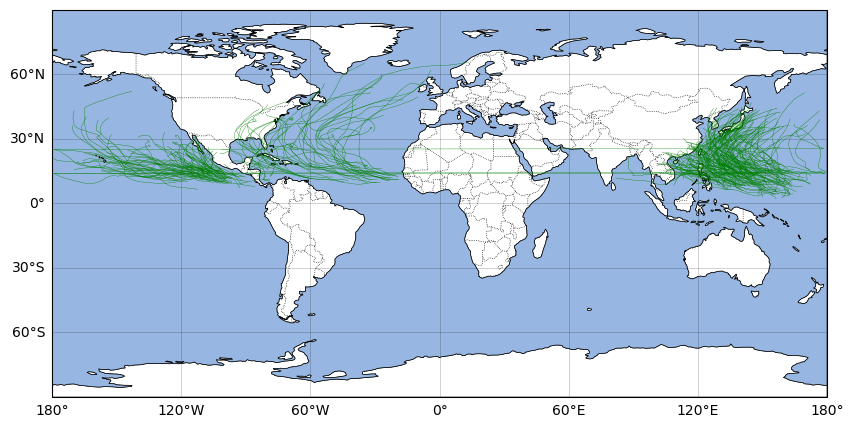

In [52]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

plt_area=[-180, 180, -90, 90]
# plt_area=[-180, 180, -45, 45]
ax.set_extent(plt_area, crs=ccrs.PlateCarree())

# Add coastlines and borders
featurewidth=0.5
# ax.coastlines(linewidth=featurewidth)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=featurewidth)#, facecolor='none')

# Add gridlines
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='black', linewidth=featurewidth, alpha=0.25)#, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add additional features if needed
ax.add_feature(cfeature.LAND, edgecolor='black', linewidth=featurewidth, facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', linewidth=featurewidth)#, facecolor='none')
# ax.add_feature(cfeature.LAKES, alpha=0.5, edgecolor='black', linewidth=featurewidth, facecolor='none')
# ax.add_feature(cfeature.RIVERS, edgecolor='black', linewidth=featurewidth, facecolor='none')

for istorm in range(len(subset_lon)):
    # ax.plot(lon, lat, marker='o', color='red', markersize=5, transform=ccrs.PlateCarree())
    ax.plot(subset_lon[istorm], subset_lat[istorm], color='green', transform=ccrs.PlateCarree(), linewidth=0.25)

# plt.savefig(figdir+plot_name+"_"+hr_tag[0:-3]+".pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close()